# Explore Deriative Analysis

In [26]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from ocpy.hydrolight import loisel23
from ocpy.utils import plotting as oc_plotting

from bing.models import anw as boring_anw
from bing.models import bbnw as boring_bbnw
from bing.models import utils as model_utils
from bing.models import functions
from bing import inference as big_inf
from bing import rt as big_rt
from bing import chisq_fit


In [27]:
%matplotlib ipympl

# Load up

In [28]:
ds = loisel23.load_ds(4,0)

In [29]:
l23_wave = ds.Lambda.data
l23_Rrs = ds.Rrs.data
all_a = ds.a.data
all_bb = ds.bb.data
all_adg = ds.ag.data + ds.ad.data
all_ad = ds.ad.data
all_ag = ds.ag.data
all_aph = ds.aph.data
all_anw = ds.anw.data

In [30]:
aw = all_a[0] - all_anw[0]

In [43]:
all_anw.shape

(3320, 81)

# Setup

In [42]:
i440 = np.argmin(np.abs(l23_wave-440.))

# $a_{\rm nw}$ histogram at 440nm

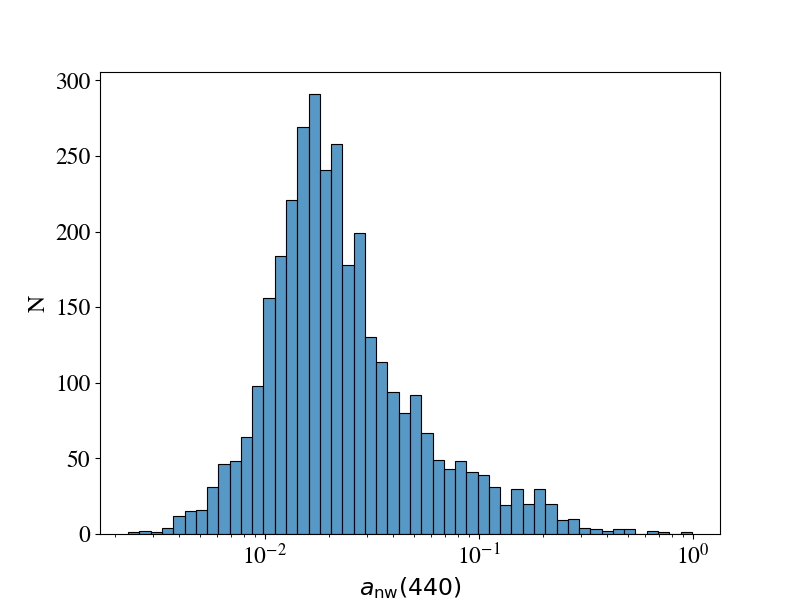

In [46]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

sns.histplot(all_anw[:,i440], log_scale=(True,False))
#
ax.set_xlabel(r'$a_{\rm nw}(440)$')
ax.set_ylabel('N')
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_xscale('log')
plt.show()

# Grab the 3 

In [49]:
idx_low = np.argmin(all_anw[:,i440])
idx_norm = 170
idx_high = np.argmax(all_anw[:,i440])

## Check

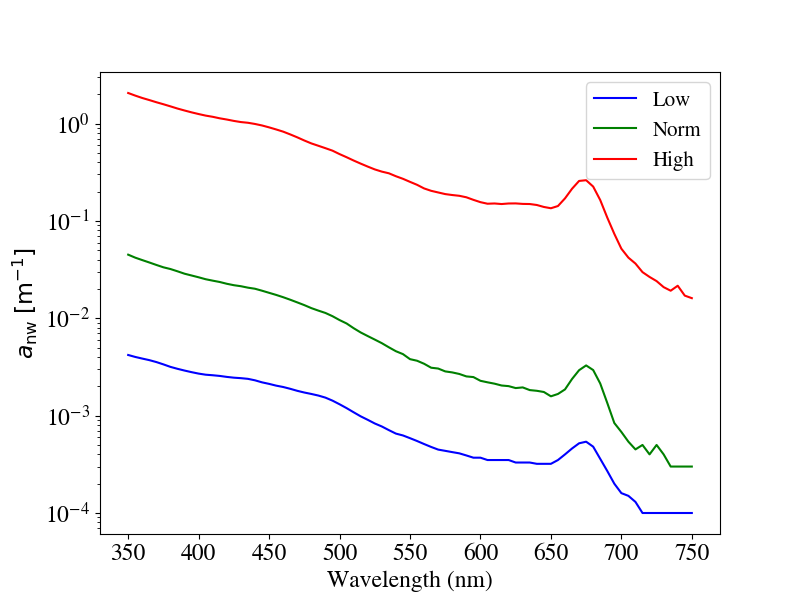

In [51]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, all_anw[idx_low], 'blue', label='Low')
ax.plot(l23_wave, all_anw[idx_norm], 'green', label='Norm')
ax.plot(l23_wave, all_anw[idx_high], 'red', label='High')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$a_{\rm nw} \; \rm [m^{-1}]$')
#
ax.set_yscale('log')
plt.show()

# $R_{\rm rs}$

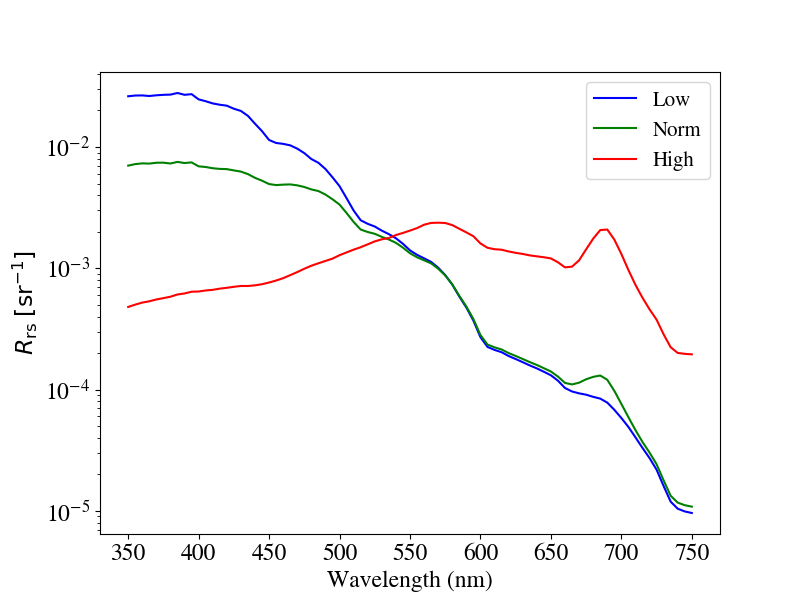

In [52]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, l23_Rrs[idx_low], 'blue', label='Low')
ax.plot(l23_wave, l23_Rrs[idx_norm], 'green', label='Norm')
ax.plot(l23_wave, l23_Rrs[idx_high], 'red', label='High')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$R_{\rm rs} \; \rm [sr^{-1}]$')
#
ax.set_yscale('log')
plt.show()

# Second derivative! $R_{\rm rs}''$

In [36]:
def d2fd2x(wave, spec):
    dwv = np.abs(np.median(np.roll(wave,1) - wave))
    #
    um1 = np.roll(spec,-1)
    up1 = np.roll(spec,1)
    # Do it
    tmp = (um1 + up1 - 2*spec)
    # Set the boundaries to 0
    tmp[0] = 0
    tmp[-1] = 0
    #import pdb; pdb.set_trace()
    return tmp/dwv**2

## Calculate em

In [37]:
d2a = d2fd2x(l23_wave, a)
d2aph = d2fd2x(l23_wave, aph)
d2ag = d2fd2x(l23_wave, ag)
d2ad = d2fd2x(l23_wave, ad)
d2aw = d2fd2x(l23_wave, aw)

## Plot em

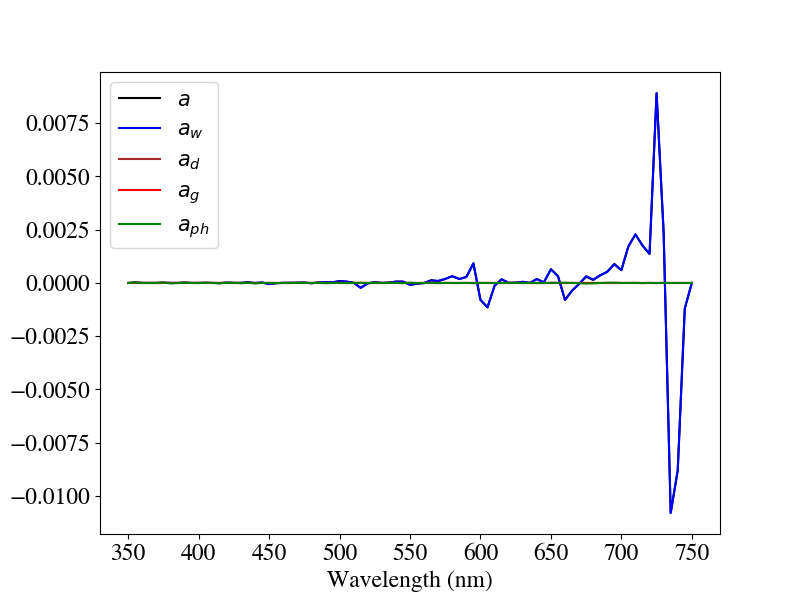

In [38]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, d2a, 'k', label=r'$a$')
ax.plot(l23_wave, d2aw, 'b', label=r'$a_w$')
ax.plot(l23_wave, d2ad, color='brown', label=r'$a_d$')
ax.plot(l23_wave, d2ag, color='r', label=r'$a_g$')
ax.plot(l23_wave, d2aph, color='green', label=r'$a_{ph}$')
#
#ax.plot(l23_wave, aw+ad+ag+aph, color='gray', ls=':', label=r'$a_{ph}$')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$d^2 x / d\lambda^2$')
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_yscale('log')
plt.show()

## Magnitude $|d^2 x / d\lambda^2|$

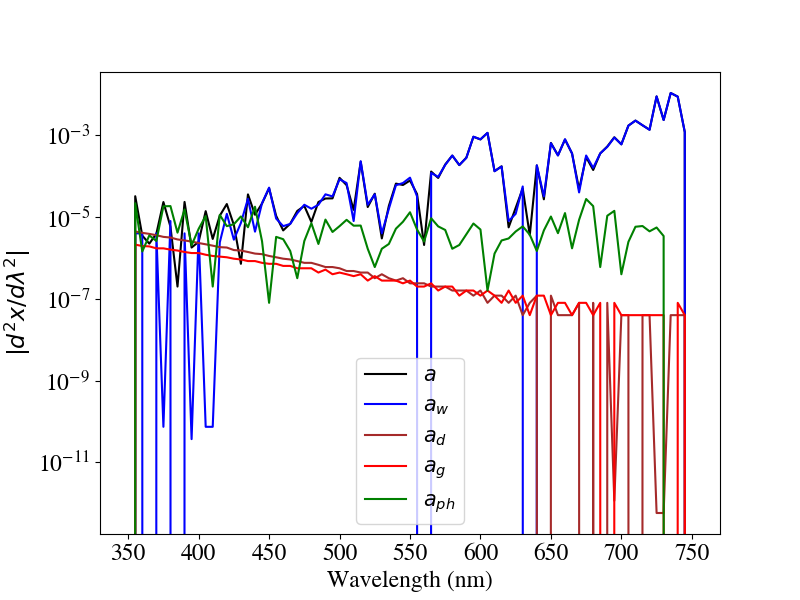

In [25]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, np.abs(d2a), 'k', label=r'$a$')
ax.plot(l23_wave, np.abs(d2aw), 'b', label=r'$a_w$')
ax.plot(l23_wave, np.abs(d2ad), color='brown', label=r'$a_d$')
ax.plot(l23_wave, np.abs(d2ag), color='r', label=r'$a_g$')
ax.plot(l23_wave, np.abs(d2aph), color='green', label=r'$a_{ph}$')
#
#ax.plot(l23_wave, aw+ad+ag+aph, color='gray', ls=':', label=r'$a_{ph}$')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$|d^2 x / d\lambda^2|$')
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
ax.set_yscale('log')
plt.show()

----

In [39]:
idx = 170

In [40]:
a = all_a[idx]
adg = all_adg[idx]
ad = all_ad[idx]
ag = all_ag[idx]
aph = all_aph[idx]

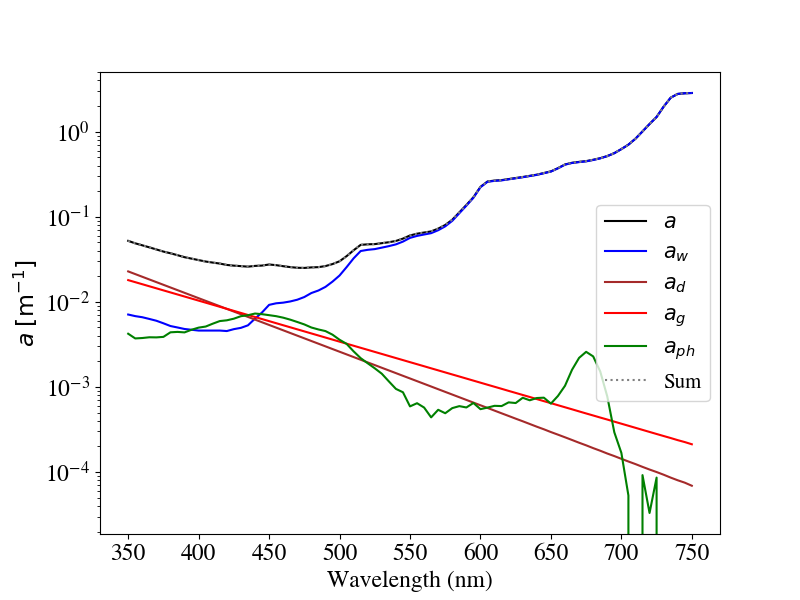

In [41]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, a, 'k', label=r'$a$')
ax.plot(l23_wave, aw, 'b', label=r'$a_w$')
ax.plot(l23_wave, ad, color='brown', label=r'$a_d$')
ax.plot(l23_wave, ag, color='r', label=r'$a_g$')
ax.plot(l23_wave, aph, color='green', label=r'$a_{ph}$')
#
ax.plot(l23_wave, aw+ad+ag+aph, color='gray', ls=':', label='Sum')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$a \; \rm [m^{-1}]$')
#
ax.set_yscale('log')
plt.show()